# Bernoulli Verification Example - Helix

Linear elastic solution of a helix in 3d. The starting and ending points of the helix lie on the X axis. One of the ends is fully constrained, and a force is applied on the free end in X direction. The test is succesful if:

- the free end makes motion only in X direction
- on the constrained end, only a force in X direction is invoked, despite all dofs being constrained

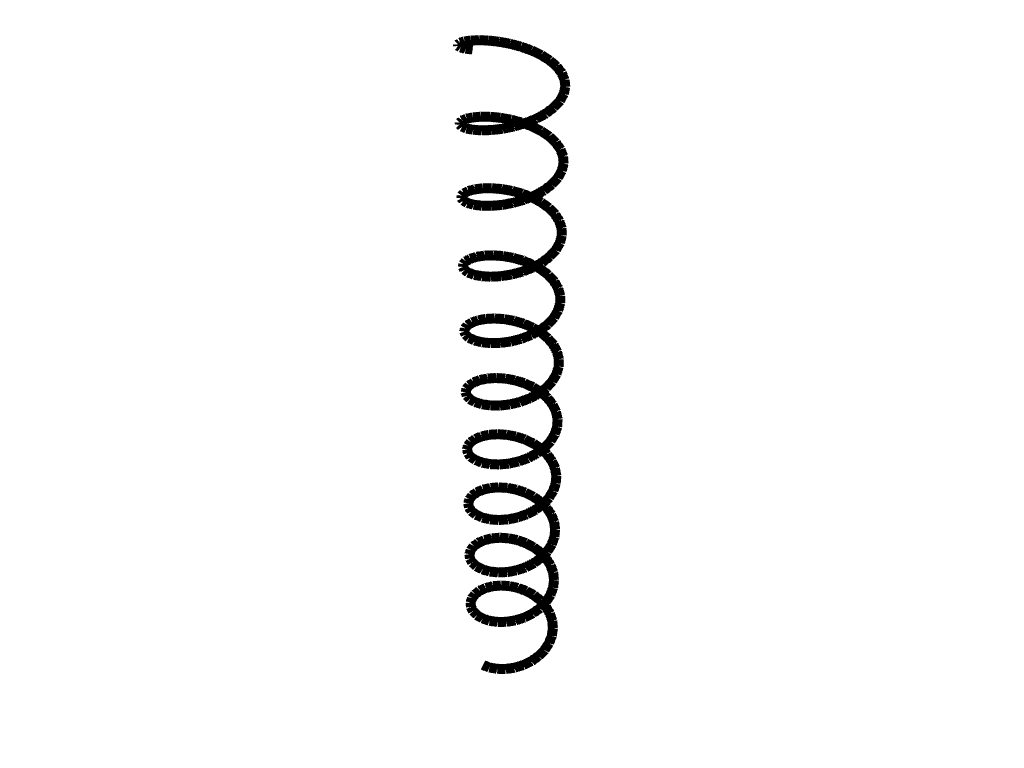

In [1]:
from polymesh.space import CartesianFrame
from polymesh import PolyData, LineData
from polymesh.recipes import circular_helix
import numpy as np

frame = CartesianFrame(dim=3)

L = 8.0

space = np.linspace(0, 20*np.pi, 300)
coords = np.array(list(map(circular_helix(L, 2), space)))
topo = np.zeros((coords.shape[0] - 1  , 2))
topo[:, 0] = np.arange(topo.shape[0])
topo[:, 1] = topo[:, 0] + 1
topo = topo.astype(int)

mesh = PolyData(coords=coords, frame=frame)
mesh['helix'] = LineData(topo=topo, frame=frame)

mesh.plot(notebook=True, jupyter_backend='static')

In [2]:
from sigmaepsilon.solid import Structure, LineMesh, PointData
from sigmaepsilon.solid.fem.cells import B2 as Beam
from neumann.linalg import Vector
from polymesh.space import StandardFrame, frames_of_lines
from polymesh.topo.tr import L2_to_L3
from polymesh.space.utils import index_of_closest_point
  
import numpy as np

xEnd = coords[-1]
if Beam.NNODE == 3:
    coords, topo = L2_to_L3(coords, topo)
iN = index_of_closest_point(coords, xEnd)

w, h = 1., 1.  # width and height of the rectangular cross section
F = 100.  # value of the vertical load at the free end
E = 210000.0  # Young's modulus
nu = 0.3  # Poisson's ratio

# cross section
A = w * h  # area
Iy = w * h**3 / 12  # second moment of inertia around the y axis
Iz = h * w**3 / 12  # second moment of inertia around the z axis
Ix = Iy + Iz  # torsional inertia

# model stiffness matrix
G = E / (2 * (1 + nu))
Hooke = np.array([
    [E*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, E*Iy, 0],
    [0, 0, 0, E*Iz]
])

# space
GlobalFrame = StandardFrame(dim=3)

# support at the first, load at the last node
loads = np.zeros((coords.shape[0], 6))
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
global_load_vector = Vector([0., 0, F], frame=GlobalFrame).show()
loads[iN, :3] = global_load_vector
fixity[0, :3] = True

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)
mesh = LineMesh(pd, frame=GlobalFrame)

# celldata
frames = frames_of_lines(coords, topo)
cd1 = Beam(topo=topo[:10], frames=frames[:10])
cd2 = Beam(topo=topo[10:], frames=frames[10:])
mesh['helix', 'A'] = LineMesh(cd1, model=Hooke)
mesh['helix', 'B'] = LineMesh(cd2, model=Hooke)
structure = Structure(mesh=mesh)
structure.linear_static_analysis()

# postproc
# 1) displace the mesh
dofsol = structure.nodal_dof_solution()
internal_forces = structure.internal_forces()
reactions = structure.reaction_forces()


In [3]:
frame0 = StandardFrame(frames[0])
forces = Vector(internal_forces[0, 0, :3], frame=frame0).show(GlobalFrame)
reactions[0], forces

(array([-9.37870936e-09, -3.17540980e-08, -1.00000000e+02,  5.11590770e-12,
        -1.09139364e-11,  1.81898940e-11]),
 array([9.47028971e-09, 3.17686440e-08, 1.00000000e+02]))

In [4]:
reactions[0, 2], forces[2]

(-99.99999998896237, 99.99999998893318)

In [5]:
structure.internal_forces(target='global')[0, 0]

array([ 9.47028989e-09,  3.17686428e-08,  1.00000000e+02, -4.88201581e-11,
        1.84679292e-11,  4.65113826e-12])

In [6]:
structure.internal_forces(target=GlobalFrame)[0, 0]

array([ 9.47028989e-09,  3.17686428e-08,  1.00000000e+02, -4.88201581e-11,
        1.84679292e-11,  4.65113826e-12])

In [7]:
structure.internal_forces(target='global')
structure.internal_forces(target='local')
structure.internal_forces(target='global', cells=[0, 5])
structure.mesh['helix', 'A'].cd.internal_forces(target='global', cells=[0, 5])
structure.external_forces(target='global')
structure.external_forces(target='local')
structure.external_forces(target='global', cells=[0, 5])
structure.mesh['helix', 'A'].cd.external_forces(target='local', cells=[0, 5])
structure.internal_forces(target=GlobalFrame)
structure.internal_forces(target=StandardFrame(frames[0]))
structure.mesh['helix', 'A'].cd.internal_forces(target=GlobalFrame, cells=[0]);
